# Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import seaborn as sns; sns.set()
import datetime as dt
sns.set(rc={'figure.figsize':(20, 10)})

## Import Data

In [5]:
Indicator=pd.read_csv("/home/tirayr/pythonscripts/MyPjOne/data/work/Market_Indicator_data_nudget_AIRBUS.out"
                   ,"|"
                   ,engine='python'
                   ,index_col=1
                   ,parse_dates=True)
News=pd.read_csv("/home/tirayr/pythonscripts/MyPjOne/data/daily/20200517/Final_FinNews_Analysed/AIRBUS_20170715_20200424.csv"
                   ,"|"
                   ,engine='python'
                   ,index_col=0
                   ,parse_dates=True)

# First Look

In [4]:
Indicator.head(n=5)
# News.head()

,COMPANY,30MIN_SUMMED_NUDGET,SYMBOL_NAME,INSTR_CODE,TRADE_VENUE,TRADE_CURRENCY,MMT_MKT_MECH,MMT_TRD_MODE,MMT_ALGO_IND,DOMINATED_AGGRESSOR_SIDE
TIME,,,,,,,,,,
2017-07-17 07:30:00,AIRBUS,-569464.04,ISN::MS160::NL0000235190,1.0,XPAR,EUR,1,2,NaN,S
2017-07-17 08:00:00,AIRBUS,-258709.99,ISN::MS160::NL0000235190,1.0,XPAR,EUR,1,2,NaN,S
2017-07-17 08:30:00,AIRBUS,-213174.58,ISN::MS160::NL0000235190,1.0,XPAR,EUR,1,2,NaN,S
2017-07-17 09:00:00,AIRBUS,657298.46,ISN::MS160::NL0000235190,1.0,XPAR,EUR,1,2,NaN,B
2017-07-17 09:30:00,AIRBUS,614818.76,ISN::MS160::NL0000235190,1.0,XPAR,EUR,1,2,NaN,B


# Prepare/Filter News Data

In [6]:
News=News.groupby(['time_index']).agg(lambda x : x.mean() if x.dtype=='float64' else ' '.join(x))
News.loc[(News['sentiment_score']<0.5) & (News['sentiment_score'])>-0.5,'prediction'] ='neutral'
News.loc[News['sentiment_score']>0.5,'prediction'] ='positive'
News.loc[News['sentiment_score']<-0.5,'prediction'] ='negative'

startT = dt.time(9,0,0)
endT   = dt.time(15,30,0)

News['date']    = pd.to_datetime(News.index)
News.index      = News['date']
News['day']     = News.index.date
News['time']    = News.index.time
News['weekday'] = News.index.weekday

News_Filtered = News.loc[  (News['date'].dt.time>startT) 
                         & (News['date'].dt.time<endT) 
#                          & (News['prediction'] != 'neutral')
                         & (News['weekday']    != 5)
                         & (News['weekday']    != 6)][['sentence','logit','prediction','sentiment_score','weekday','day','time']]
News_Filtered.describe

<bound method NDFrame.describe of                                                               sentence  \
date                                                                     
2017-07-06 14:13:11  CORRECTED-Qatar Airways CEO says Airbus A350 d...   
2017-07-07 12:55:52  Austria plans to end Eurofighter program early...   
2017-07-11 11:28:20  BRIEF-Air Transat signs an agreement to lease ...   
2017-07-13 10:48:30  Leonardo, Airbus to bid for UK 'Top Gun' train...   
2017-07-20 10:57:57  Oman Air in talks with Airbus, Boeing to expan...   
2017-07-26 15:03:03  Airbus A350 goals on track, but A320neo plans ...   
2017-07-27 15:05:13  Pratt & Whitney in hot seat as Airbus profits ...   
2017-07-28 13:21:53  BRIEF-Motorola Solutions acquires Airbus DS Co...   
2017-07-31 10:41:38  BRIEF-Air Lease Corp announces lease placement...   
2017-08-01 12:14:04  This double-decker giant carries more than 500...   
2017-08-09 12:55:40  Qatar Airways says will receive first Airbus A...   
2017

11872


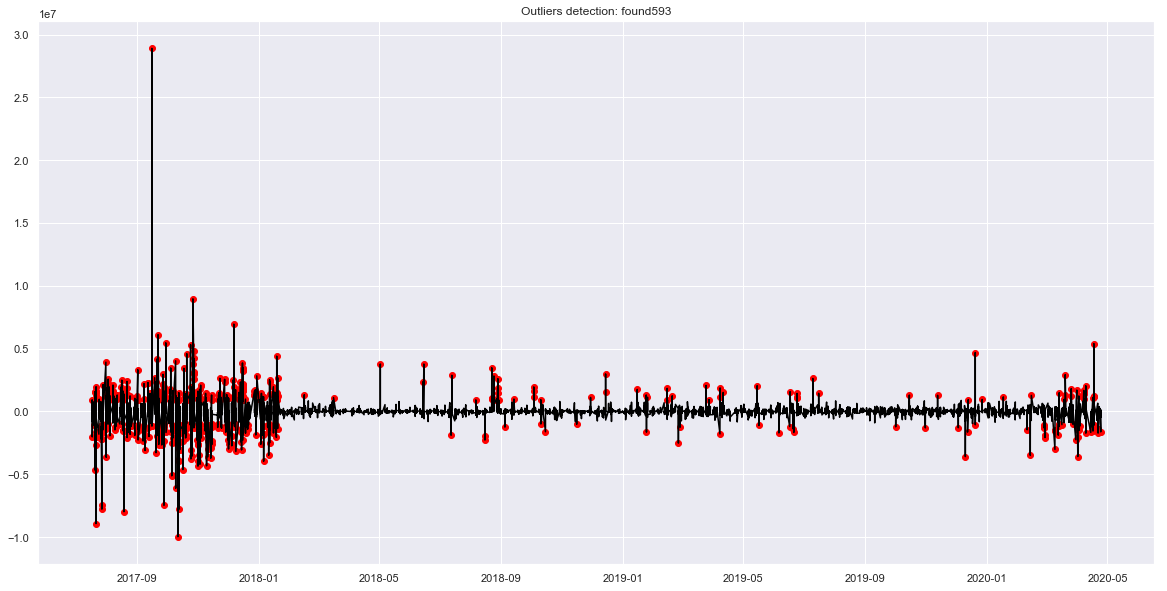

In [7]:
## For data
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import datetime
## For plotting
import matplotlib.pyplot as plt
## For outliers detection
from sklearn import preprocessing, svm
## For stationarity test and decomposition
import statsmodels as smt
from statsmodels import *
# import statsmodels.api as sm

## create time series
dtf = Indicator #.loc['201']
ts  = dtf['30MIN_SUMMED_NUDGET']
# ts  = dtf.groupby(dtf.index)["30MIN_SUMMED_NUDGET"].sum().rename("30MIN_SUMMED_NUDGET")

print(len(ts))
# ts.hist(color="black", bins=200)
def plot_ts(ts, plot_ma=True, plot_intervals=True, window=30,
            figsize=(20,10)):    
    rolling_mean = ts.rolling(window=window).mean()    
    rolling_std  = ts.rolling(window=window).std()
    plt.figure(figsize=figsize)    
    plt.title(ts.name)    
    plt.plot(ts[window:], label='Actual values', color="black")    
    if plot_ma:        
        plt.plot(rolling_mean, 'g', label='MA'+str(window),
               color="red")    
    if plot_intervals:
        lower_bound = rolling_mean - (1.96 * rolling_std)
        upper_bound = rolling_mean + (1.96 * rolling_std)
    plt.fill_between( x    = ts.index,
                      y1   = lower_bound,
                      y2   = upper_bound,
                      color= 'lightskyblue',
                      alpha= 0.4)
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()
def find_outliers(ts, perc=0.01, figsize=(20,10)):
    ## fit svm
    scaler    = preprocessing.StandardScaler()
    ts_scaled = scaler.fit_transform(ts.values.reshape(-1,1))
    model     = svm.OneClassSVM(nu=perc, kernel="rbf", gamma=0.01)
    model.fit(ts_scaled)
    ## dtf output
    dtf_outliers = ts.to_frame(name="ts")
    dtf_outliers["index"]   = range(len(ts))
    dtf_outliers["outlier"] = model.predict(ts_scaled)
    dtf_outliers["outlier"] = dtf_outliers["outlier"].apply(lambda
                                             x: 1 if x==-1 else 0)
#     days = dates.DayLocator()
    ## plot
    fig, ax = plt.subplots(figsize=figsize)
#     fig.autofmt_xdate()
#     ax.xaxis.set_major_locator(days)
    ax.set(title="Outliers detection: found"
           +str(sum(dtf_outliers["outlier"]==1)))
    ax.plot(dtf_outliers.index, dtf_outliers["ts"],
            color="black")
    ax.scatter(x=dtf_outliers[dtf_outliers["outlier"]==1].index,
               y=dtf_outliers[dtf_outliers["outlier"]==1]['ts'],
               color='red')
    ax.grid(True)
    plt.show()
    return dtf_outliers


dtf_outliers = find_outliers(ts, perc=0.05)
# dtf_outliers[dtf_outliers['outlier'] == 1].head(n=5000)
# dtf_outliers[dtf_outliers["outlier"]==1].index
# plot_ts(ts, window=7)
# plot_ts(ts, window=30)

In [9]:
# # News=News.groupby(['time_index']).agg(lambda x : x.mean() if x.dtype=='float64' else ' '.join(x))
# std_df=Indicator
# std_df.dtypes
# std_df.index = pd.to_datetime(std_df.index)
# std_df.index = std_df.index.to_period('M')
# std_df=std_df.groupby([std_df.index]).agg(lambda x : x.std() if x.dtype=='float64' else ' '.join(x)) #, 'mean', 'std']
# std_df['30MIN_SUMMED_NUDGET']

# # new_df.index.set_names(['Year', 'Month'], inplace = True)
# # new_df.reset_index(inplace = True)
# # new_df

def zscore(s):
    return (s - np.mean(s)) / np.std(s)

Indicator_main= dtf_outliers



Indicator_main['day'] =Indicator_main.index.date
Indicator_main['time']=Indicator_main.index.time

Indicator_main['zscore']= zscore(Indicator_main['ts'])

Indicator_outlier = Indicator_main[Indicator_main['outlier']==1]


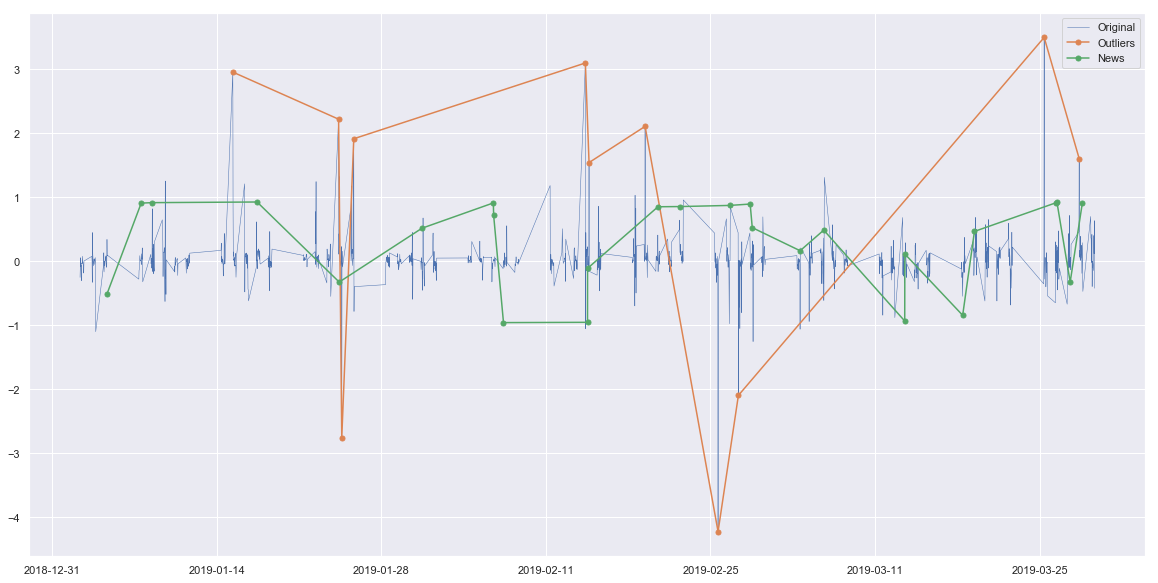

In [140]:
start, end = '2019-01', '2019-03'
fig, ax = plt.subplots()
ax.plot(Indicator_main.loc[start:end, 'zscore'],
 linestyle='-', linewidth=0.5, label='Original')

ax.plot(Indicator_outlier.loc[start:end, 'zscore'],
marker='o', markersize=5, label='Outliers')

ax.plot(News_Filtered.loc[start:end,'sentiment_score'],
marker='o', markersize=5,label='News')
ax.legend(loc='best')
ax.grid(True)

In [23]:
# zscore(Indicator['30MIN_SUMMED_NUDGET']).abs().gt(2)
# News_Filtered.head()
# News_Filtered['']


date = dt.date(1, 1, 1)
event_time_diff = 3
df_merge_difkey = pd.merge(Indicator_outlier,News_Filtered,how='outer',left_on=Indicator_outlier['day'],right_on=News_Filtered['day'])
df_merge_difkey
df_merge_difkey       = df_merge_difkey[(~df_merge_difkey['day_x'].isna()) & (~df_merge_difkey['day_y'].isna())]

df_merge_difkey['DATE']= df_merge_difkey.key_0
df_merge_difkey.index  = df_merge_difkey['DATE']

df_merge_difkey['time_x_']=df_merge_difkey['time_x'].apply(lambda x : dt.datetime.combine(date,x))
df_merge_difkey['time_y_']=df_merge_difkey['time_y'].apply(lambda x : dt.datetime.combine(date,x))

df_merge_difkey=df_merge_difkey.loc[   (df_merge_difkey['time_x_']-df_merge_difkey['time_y_']<=dt.timedelta(hours=event_time_diff))
                     & (df_merge_difkey['time_x_']-df_merge_difkey['time_y_']>=dt.timedelta(hours=2))]
df_merge_difkey
# df_merge_difkey['prediction_flag']=df_merge_difkey['prediction'].apply(lambda x:1 if x=='positive' else 0)

df_merge_difkey_compact=df_merge_difkey[['ts','time_x','zscore','time_y','sentiment_score','sentence']]
Indicator_outlier.count(axis=0)
df_merge_difkey_compact['Class']=1
df_merge_difkey_compact['Market_value']=df_merge_difkey_compact['ts']
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
df_merge_difkey_compact[['time_x','Market_value','Class','time_y','sentiment_score','sentence']]
df_merge_difkey_compact

/home/tirayr/anaconda3/envs/tirenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/tirayr/anaconda3/envs/tirenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,ts,time_x,zscore,time_y,sentiment_score,sentence,Class,Market_value
DATE,,,,,,,,
2017-07-20,1571497.31,13:00:00,2.658375,10:57:57,0.905273,"Oman Air in talks with Airbus, Boeing to expand wide-body fleet to 25 jets::::::Oman's national airline is in talks with planemakers Airbus <AIR.PA> and Boeing <BA.N> to expand its wide-body fleet to 25 jets and hopes to conclude the deal in the next two to three months, its chief executive said on Thursday.",1,1571497.31
2017-07-31,-1008679.63,13:30:00,-1.681116,10:41:38,0.419428,BRIEF-Air Lease Corp announces lease placement of Airbus TAP Portugal::::::* Air Lease Corporation announces lease placement of four new airbus a330-900neo and one new a320-200neo aircraft with TAP Portugal,1,-1008679.63
2017-08-01,1870478.84,15:00:00,3.161219,12:14:04,0.254664,"This double-decker giant carries more than 500 people and its engines are so quiet that, in the plane... Airbus::: A380 cuts signal the end of an aviation dream:::...deaths.It is an astonishing achievement — and I never feel it as keenly as I do on an A380.",1,1870478.84
2017-09-18,1392074.05,15:30:00,2.356611,13:10:48,-0.901083,Airbus challenges Austrian allegations over Eurofighter deal::::::Airbus <AIR.PA> denied any wrongdoing in a submission on Monday to Austrian prosecutors investigating allegations of fraud and willful deception over a $2 billion fighter deal and threatened the country's defense minister with legal action.,1,1392074.05
2017-09-19,2359269.91,14:00:00,3.983297,11:08:34,0.670852,"Airbus looks to China for A380 jumbo amid sluggish global sales::::::Chinese airlines could need between 60 and 100 Airbus <AIR.PA> A380 jets over the next five or so years as passenger traffic grows, the plane maker's China head said on Tuesday, amid rising questions over future demand for the super jumbo.",1,2359269.91
2017-10-11,-1843683.33,15:30:00,-3.085474,13:19:33,-0.033831,"Airbus sales boss Leahy sets end-year retirement date -sources::::::Airbus sales chief John Leahy, a dominant figure of modern aviation, has resolved one of the most widely discussed questions in aerospace by settling on a retirement date - the end of 2017, company executives said on Wednesday.",1,-1843683.33
2017-10-12,913777.92,12:00:00,1.552184,09:53:44,0.827305,"Airbus board says has full confidence in CEO Tom Enders::::::The board of Airbus expressed confidence on Thursday in Chief Executive Tom Enders as the aerospace group faces UK and French probes into suspected corruption at its planemaking subsidiary, along with an Austrian probe into a 2003 fighter deal.",1,913777.92
2017-10-12,1490474.43,13:00:00,2.522106,10:38:54,0.147015,BRIEF-Air Lease announces lease placement of one new Airbus A321neo LR aircraft with Aer Lingus::::::* Air Lease Corporation announces lease placement of one additional new Airbus A321neo LR aircraft with Aer Lingus,1,1490474.43
2017-10-17,3436125.59,14:00:00,5.794415,11:21:42,0.890580,"Lufthansa CEO expects to benefit from Airbus, Bombardier deal::::::Lufthansa will benefit from future cooperation between airplane makers Airbus and Bombardier as it is a major customer of both companies, the German airline's chief executive Carsten Spohr said.",1,3436125.59


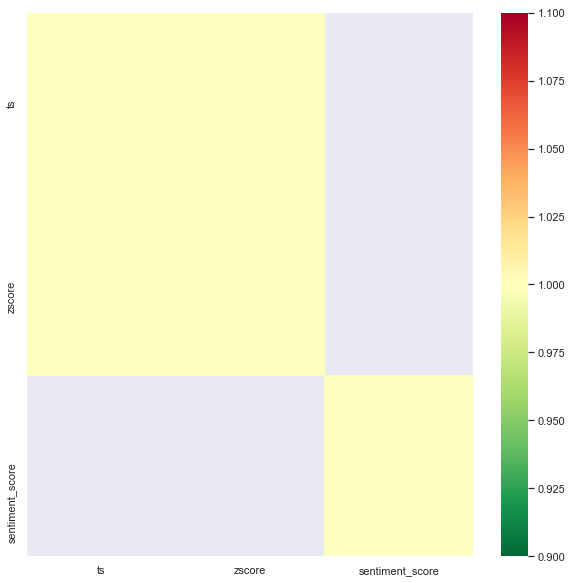

In [153]:
c = df_merge_difkey_compact.corr()
plt.figure(figsize=(10,10))
sns.heatmap(c, cmap='RdYlGn_r', mask = (np.abs(c) <= 0.8))
plt.show()

In [ ]:
News_Filtered['sentiment_score'].plot(linewidth=2,marker='o',linestyle='-',figsize=(50, 15))

In [ ]:
MyDataIndicator.loc['2020-02','30MIN_SUMMED_NUDGET'].plot(linewidth=0.5,marker='.', linestyle='-')

In [ ]:
MyDataNews.loc['2020-02','sentiment_score'].plot(linewidth=2,marker='o',linestyle='-',figsize=(10, 5))

In [ ]:

MyData_weekly_mean = MyData['30MIN_SUMMED_NUDGET'].resample('W').mean()
MyData_7d          = MyData['30MIN_SUMMED_NUDGET'].rolling(7, center=True).mean()
# Start and end of the date range to extract
start, end = '2019-01', '2019-06'
# Plot daily, weekly resampled, and 7-day rolling mean time series together
fig, ax = plt.subplots()
ax.plot(MyData.loc[start:end, '30MIN_SUMMED_NUDGET'],
marker='.', linestyle='-', linewidth=0.5, label='Original')
ax.plot(MyData_weekly_mean.loc[start:end, '30MIN_SUMMED_NUDGET'],
marker='o', markersize=8, linestyle='-', label='Weekly Mean Resample')
ax.plot(MyData_7d.loc[start:end, '30MIN_SUMMED_NUDGET'],
marker='.', linestyle='-', label='7-d Rolling Mean')
ax.set_ylabel('Solar Production (GWh)')
ax.legend();

In [ ]:
ax=MyData['30MIN_SUMMED_NUDGET'].plot(linewidth=0.1, marker='.', alpha=0.5, linestyle='None', figsize=(20, 10))
ax.set_ylabel('TIME')

In [ ]:
cols_plot = ['30MIN_SUMMED_NUDGET']
axes = opsd_daily[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')